In [1]:
from tensorflow.keras import models, layers, optimizers, callbacks, backend
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import time
import pickle
import sys

/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/nicolas/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file 

In [2]:
data1 = np.load("training/data/1OverF_1.npz")
c_data = data1['arr_0']       # C data
T_in = data1['arr_1']         # Time vector for data generation 
s_data = data1['arr_2']       # S data
w0 = data1['arr_3']           # Omega vector for data generation
T_train = data1['arr_4']      # Time vector for training data (based on the experimental data)
w_train = data1['arr_5']      # Omega vector for training data
T2_span = data1['arr_6']      # T2 distribution

In [3]:
# For data interpolation
def interpData(x,y,xNew):
    f_interp = interp1d(x,y)
    yNew = f_interp(xNew)
    return yNew

# For preparing training data: Add random noise, then replace low values with zeros
# Run this cell multiple times to generate sets with different random noise but same underlying curves
def prepare_trainData(c_in,T_in,T_train,noiseMax=0.03,cutOff=0.03):
    c_train = interpData(T_in,c_in,T_train)
    for i in range(c_in.shape[0]):
        c_train[i,:] = c_train[i,:] + np.random.normal(0,noiseMax*2/3,size=c_train.shape[1])
        cut = np.squeeze(np.argwhere(c_train[i,:]<=cutOff+np.random.normal(0,noiseMax*2/3,1)))
    if cut.size > 1:
        c_train[i,cut[0]-1:] = 0
    elif cut.size == 1:
        c_train[i,cut-1:] = 0
    return c_train

In [6]:
nnps = 6 #-- noise number per sample
# Interpolate, add random noise to experimental conditions, cut the tail of the data
c_train_1set = prepare_trainData( c_data, T_in, T_train )
s_train_1set = interpData( w0, s_data, w_train )
d1 = np.shape( c_train_1set )[0]
d2 = np.shape( c_train_1set )[1]
d3 = np.shape( s_train_1set )[1]
c_train = np.zeros( ( d1*nnps, d2 ) )
s_train = np.zeros( ( d1*nnps, d3 ) )
for i in range(nnps):
    c_train_1set = prepare_trainData( c_data, T_in, T_train, noiseMax=0.015,cutOff=0.03 )
    c_train[i*d1:(i+1)*d1,:] = c_train_1set
    s_train[i*d1:(i+1)*d1,:] = s_train_1set

X = c_train
y = s_train
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)    

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))
print("w_train = ",np.shape(w_train))

x_train =  (30064, 147)
y_train =  (30064, 501)
x_test =  (5306, 147)
y_test =  (5306, 501)
w0 =  (4001,)
w_train =  (501,)


In [7]:
def get_model( filter_nb, kernel_size, pool_size, dropout_rate ):
    model = models.Sequential()
    model.add( layers.Input( shape=(x_train.shape[-1], 1) ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//2, kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    
    model.add( layers.Conv1D( filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    
    model.add( layers.Conv1D( filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D( 1, kernel_size, activation="relu", padding='same' ) )
    model.add( layers.Flatten() )
    model.add( layers.Dropout( dropout_rate ) )
    model.add( layers.Dense(501, activation='linear') )  
    
    return model 

In [20]:
BATCH_SIZE = 64
EPOCHS = 20
INIT_LR = 1e-5
MAX_LR = 1e-3

model = get_model( filter_nb=20, kernel_size=48, pool_size=2, dropout_rate=0.05 )
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 147, 20)           980       
                                                                 
 conv1d_28 (Conv1D)          (None, 147, 20)           19220     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 74, 20)           0         
 1D)                                                             
                                                                 
 conv1d_29 (Conv1D)          (None, 74, 10)            9610      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 37, 10)           0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 37, 5)            

## SINGLE MODEL TRAINING

In [11]:
LR=0.001
BATCH_SIZE = 64
EPOCHS1 = 4*3

model = get_model( filter_nb=40, kernel_size=42, pool_size=2, dropout_rate=0.05 )

opt1 = optimizers.Adam(learning_rate=LR)
model.compile(loss='MAPE', optimizer=opt1)
history1_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS1,\
                         validation_data=(x_test, y_test), verbose=True )

EPOCHS2 = 4*5
INIT_LR = 2e-5
MAX_LR = 1e-3
steps_per_epoch = len(x_train) // BATCH_SIZE

clr2 = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
        maximal_learning_rate=MAX_LR,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * steps_per_epoch)
opt2 = optimizers.Adam(clr2)
model.compile(loss='MAPE', optimizer=opt2)
history2_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS2,\
                         validation_data=(x_test, y_test), verbose=True )


Epoch 1/12


2023-07-03 12:39:24.031966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 71.3540

2023-07-03 12:39:42.407929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 20s 40ms/step - loss: 71.3540 - val_loss: 26.7867
Epoch 2/12
470/470 [==============================] - 19s 41ms/step - loss: 22.2184 - val_loss: 14.0373
Epoch 3/12
470/470 [==============================] - 17s 37ms/step - loss: 14.6508 - val_loss: 13.3442
Epoch 4/12
470/470 [==============================] - 18s 37ms/step - loss: 12.7083 - val_loss: 9.8365
Epoch 5/12
470/470 [==============================] - 17s 37ms/step - loss: 10.8509 - val_loss: 9.6502
Epoch 6/12
470/470 [==============================] - 17s 37ms/step - loss: 9.4933 - val_loss: 10.8927
Epoch 7/12
470/470 [==============================] - 17s 37ms/step - loss: 9.4596 - val_loss: 12.8783
Epoch 8/12
470/470 [==============================] - 18s 37ms/step - loss: 9.2904 - val_loss: 7.8313
Epoch 9/12
470/470 [==============================] - 18s 38ms/step - loss: 8.6562 - val_loss: 7.4298
Epoch 10/12
470/470 [==============================] - 18s 38ms/step - loss: 8.5123

2023-07-03 12:42:59.147900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - ETA: 0s - loss: 6.2519

2023-07-03 12:43:17.359620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 20s 40ms/step - loss: 6.2519 - val_loss: 5.8886
Epoch 2/20
470/470 [==============================] - 17s 37ms/step - loss: 7.3918 - val_loss: 8.3947
Epoch 3/20
470/470 [==============================] - 18s 38ms/step - loss: 7.2332 - val_loss: 5.4416
Epoch 4/20
470/470 [==============================] - 18s 37ms/step - loss: 5.6950 - val_loss: 4.8646
Epoch 5/20
470/470 [==============================] - 18s 37ms/step - loss: 5.4727 - val_loss: 5.4515
Epoch 6/20
470/470 [==============================] - 18s 37ms/step - loss: 6.2592 - val_loss: 5.5651
Epoch 7/20
470/470 [==============================] - 17s 37ms/step - loss: 6.1758 - val_loss: 5.0419
Epoch 8/20
470/470 [==============================] - 18s 37ms/step - loss: 5.3084 - val_loss: 4.7270
Epoch 9/20
470/470 [==============================] - 18s 37ms/step - loss: 5.2157 - val_loss: 5.0034
Epoch 10/20
470/470 [==============================] - 18s 38ms/step - loss: 5.5493 - val_los

In [12]:
model.save('training/model_lr+clr_fil=20', overwrite=True)

INFO:tensorflow:Assets written to: training/model_lr+clr_fil=20/assets


INFO:tensorflow:Assets written to: training/model_lr+clr_fil=20/assets


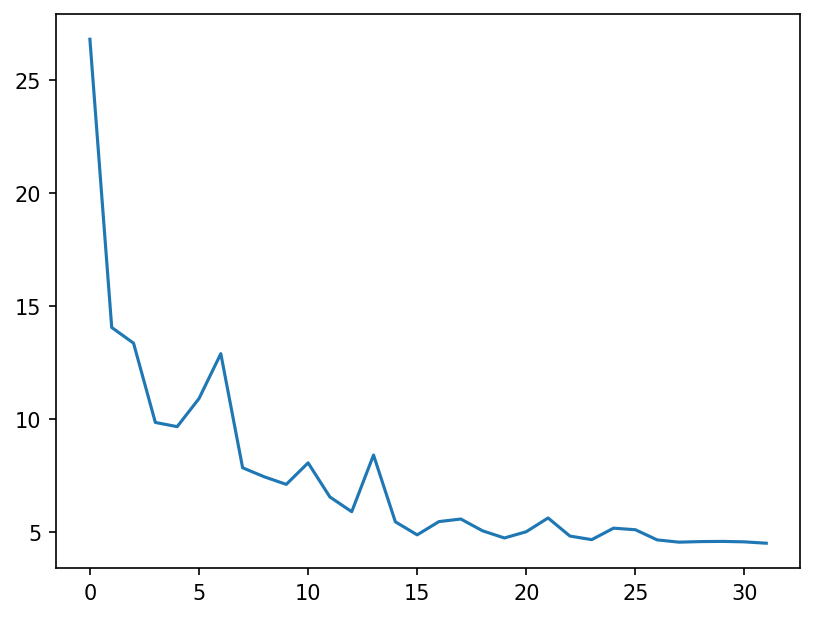

In [14]:
#tot_history = history1_.history['val_loss'] 
tot_history = np.append( history1_.history['val_loss'],history2_.history['val_loss'] )
#tot_history = np.append( tot_history,history3_.history['val_loss'] )

#epochs = np.arange( 0, EPOCHS1 )
epochs = np.arange( 0, EPOCHS1+EPOCHS2 )

plt.plot( epochs, tot_history )
plt.show()


## SWEEPING HYPER-PARAMETERS 

In [26]:
label1 = 'number_of_filters'
label2 = 'kernel_size'

parameters1_arr = np.arange( 12,40,1 )  #-- number of filters
parameters2_arr = np.arange( 12,40,1 )  #-- kernel size
batch_size_size_arr = [64]
pairs = []
for p1 in parameters1_arr:
    for p2 in parameters2_arr:
        pairs.append([p1,p2])
        
training_losses = {}
validation_losses = {}

nb_of_points = len(parameters1_arr)*len(parameters2_arr)
print(label1, parameters1_arr)
print(label2, parameters2_arr)
print(len(parameters1_arr),len(parameters2_arr),nb_of_points)

number_of_filters [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39]
kernel_size [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39]
28 28 784


In [27]:
epochs=80
best_loss = 1000
worst_loss = -1

t1=time.time()
print('-- nb of points =',nb_of_points )

from datetime import datetime
now = datetime.now()
t_string = now.strftime("%d_%m||%Hh%M")
print("-- t_string", t_string)

if (nb_of_points != len(pairs)):
    print("-- ABORT: parameter sweep already started.")
    sys.exit()


count=0
while pairs:
    
    count +=1
    rand_int = np.random.randint(0, len(pairs))
    pair = pairs[rand_int]
    p1 = int( pair[0] )
    p2 = int( pair[1] )
    pairs.remove(pair)

    print('.',end=' ' )
    
    for bs in batch_size_size_arr:
        
        reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5,verbose=0,\
            mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-5)
        model = get_model( filter_nb=p1, kernel_size=p2, pool_size=2, dropout_rate=0.05 )
        opt = optimizers.Adam(learning_rate=0.001)
        model.compile(loss='MAPE', optimizer=opt)
        history_ = model.fit( x_train, y_train, 64, epochs=epochs,\
                         validation_data=(x_test, y_test), verbose=0, callbacks=[reduce_lr])

        training_losses[ p1 , p2, bs ] = history_.history['loss'][-1]
        validation_losses[ p1 ,p2, bs ] = history_.history['val_loss'][-1]
        if count > 1:
            with open('training/training_losses_'+t_string+'.pkl', 'wb') as f1:
                pickle.dump(training_losses, f1)
            with open('training/validation_losses_'+t_string+'.pkl', 'wb') as f2:
                pickle.dump(validation_losses, f2)

        if (validation_losses[ p1 , p2, bs ] < best_loss):
            model.save('training/best_model_'+t_string, overwrite=True)
            with open('training/best_history_'+t_string+'.pkl', 'wb') as f3:
                pickle.dump( history_.history , f3)
            best_loss = validation_losses[ p1 , p2, bs ]
            best_p1=p1
            best_p2=p2
        
        del model
        del history_
        

t2=time.time()
print(' ')
print('=== COMPLETE ===')
print("-- total time = ", t2-t1)
print("-- best {}, {} =".format(label1, label2), best_p1, best_p2)
print("-- t_string", t_string)


-- nb of points = 784
-- t_string 03_07||13h14
. 

2023-07-03 13:14:22.131119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-03 13:14:36.325876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: training/best_model_03_07||13h14/assets


INFO:tensorflow:Assets written to: training/best_model_03_07||13h14/assets


. 

2023-07-03 13:15:03.318526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-03 13:15:19.288035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: training/best_model_03_07||13h14/assets


INFO:tensorflow:Assets written to: training/best_model_03_07||13h14/assets


. 

2023-07-03 13:15:51.682794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-03 13:16:06.792104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


. 

2023-07-03 13:16:33.552545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-03 13:16:50.524876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


. 

2023-07-03 13:17:21.725349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-03 13:17:38.417559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

Best parameters = number_of_filters kernel_size dr = 36 22 64 10.485536575317383


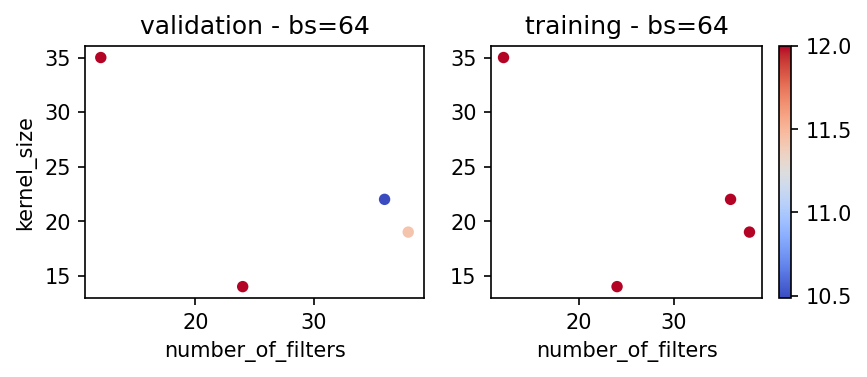

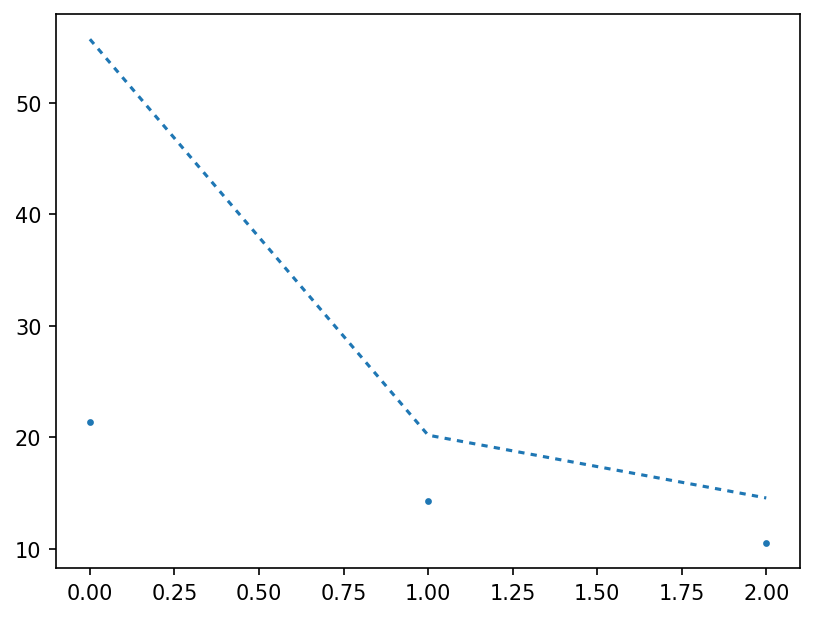

In [30]:
from collections import defaultdict

matplotlib.rcParams['figure.dpi']=150
t_string="03_07||13h14"
with open('training/training_losses_'+t_string+'.pkl', 'rb') as f1:
    training_losses = pickle.load(f1)
with open('training/validation_losses_'+t_string+'.pkl', 'rb') as f2:
    validation_losses = pickle.load(f2)
with open('training/best_history_'+t_string+'.pkl', 'rb') as f3:
    best_history = pickle.load(f3)


min_val = min(validation_losses, key=validation_losses.get)
print( "Best parameters = "+label1+" "+label2+' dr =', min_val[0], min_val[1],min_val[2],validation_losses[min_val] )

#x_scatter = [ x[0] for x in training_losses]
#y_scatter = [ x[1] for x in training_losses]

x_scatter = defaultdict(list)
y_scatter = defaultdict(list)
training_colors = defaultdict(list)
validation_colors = defaultdict(list)
for x in training_losses:
    x_scatter[x[2]].append(x[0])
    y_scatter[x[2]].append(x[1])
    training_colors[x[2]].append( training_losses[x]  )
    validation_colors[x[2]].append( validation_losses[x]  )


#training_colors = [training_losses[x] for x in training_losses]
#validation_colors = [validation_losses[x] for x in training_losses]


for key in x_scatter.keys():
    
    vals = list(validation_losses.values())
    
    plt.subplot(2,2,1)
    mycmap = plt.cm.coolwarm
    lognorm=matplotlib.colors.LogNorm()
    #plt.scatter( x_scatter, y_scatter, s=20, c=validation_colors, cmap=mycmap)#,norm=lognorm )
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=validation_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.ylabel(label2)
    #plt.clim( min(vals), max(vals) )
    plt.clim( min(vals), 12 )
    plt.title( 'validation - bs='+str(key) )

    plt.subplot(2,2,2)
    lognorm=matplotlib.colors.LogNorm()
    mycmap = plt.cm.coolwarm
    plt.scatter( x_scatter[key], y_scatter[key], s=20, c=training_colors[key], cmap=mycmap)#,norm=lognorm )
    plt.xlabel(label1)
    plt.title( 'training - bs='+str(key) )
    plt.clim( min(vals), 12 )
    #plt.clim( min(vals), max(vals) )
    plt.colorbar()
    
    plt.show()

plt.scatter( np.arange(len(best_history['val_loss'])), best_history['val_loss'], s=5 )
plt.plot( np.arange(len(best_history['loss'])), best_history['loss'], dashes=[2,2,2,2] )
plt.savefig('training/plots/'+t_string+'.pdf',format='pdf')
#plt.title( label1+" "+label2+' bs ='+str(min_val[0])+" "+str(min_val[1])+" "+str(min_val[2]) )
#plt.xlim(25,40)
#plt.ylim(7,15)
plt.show()

##  MODEL TESTING

In [15]:
reconstructed_model = models.load_model("training/model_lr+clr_fil=20", compile=False)

In [17]:
probability_model = tf.keras.Sequential([reconstructed_model])
#probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

  7/166 [>.............................] - ETA: 1s 

2023-07-03 12:49:44.860408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


166/166 [==============================] - 2s 8ms/step


(0.0, 500000.0)

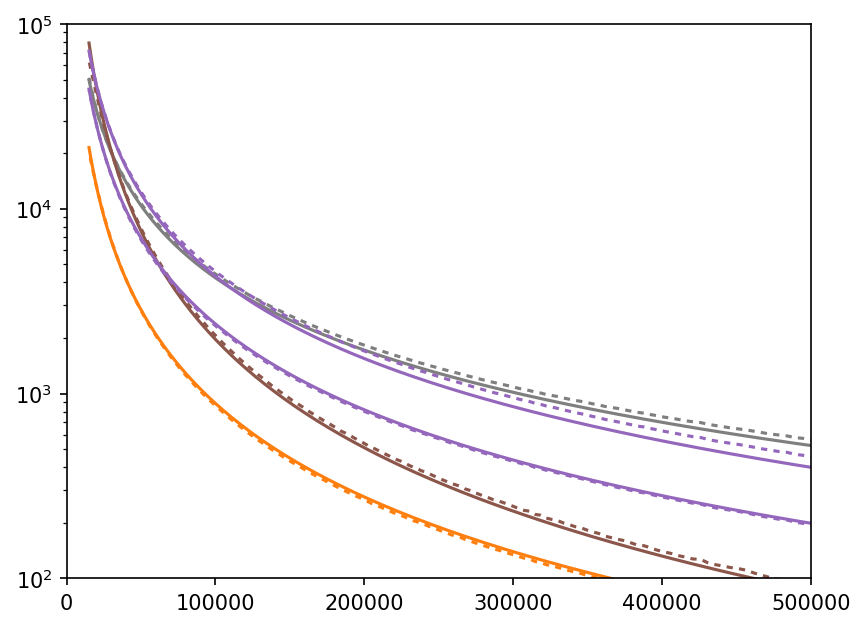

In [21]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w_train, y_test[i,:],color='C'+str(i))
    plt.plot(w_train, predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e5)
plt.xlim(0, 0.5e6)

In [ ]:
matplotlib.rcParams['figure.dpi']=300
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))